In [30]:
#read all words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)






In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [32]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

class Linear: 

    def __init__(self, fan_in: int, fan_out: int, bias:bool=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps:float=1e-5, momentum:float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [33]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)# for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

# some initialization
with torch.no_grad():
    # last layer: make less confident
    # layers[-1].gama *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True  

            

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])
22097


In [34]:
#Visualize Histograms of the Activations
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
#     if isinstance(layer, Tanh):
#         t = layer.out
#         print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('activation distribution')


In [35]:
#visualize gradients
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
#     if isinstance(layer, Tanh):
#         t = layer.out.grad
#         print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends)
# plt.title('gradient distribution')

In [36]:
# visualize weights 
# plt.figure(figsize=(20, 4))
# legends = []
# for i, p in enumerate(parameters):
#     t = p.grad
#     if p.ndim == 2:
#         print('weight %10s | mean %+f | std %e | grad: weights %e, grad %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(), p.data.std(), t.std(), t.std() / p.data.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'{i} {tuple(p.shape)}')
# plt.legend(legends)
# plt.title('weights gradient distribution');



In [37]:
# visualize weight updates 
# plt.figure(figsize=(20, 4))
# legends = []
# for i, p in enumerate(parameters):
#     if p.ndim == 2:
#         plt.plot([ud[j][i] for j in range(len(ud))])
#         legends.append('param %d' % i)
# plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, otherwise things are exploding
# plt.legend(legends);

In [38]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  embd = C[Xb]
  x = embd.view(embd.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # compute the loss
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update simple SGD
  lt = 0.1 if i < 150000 else 0.01 # learning rate 
  for p in parameters:
    if p.grad is not None:
      p.data -= lt * p.grad
      
  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 19.0037
   1000/  20000: 2.6760
   2000/  20000: 2.5388
   3000/  20000: 2.2141
   4000/  20000: 2.2855
   5000/  20000: 2.3553
   6000/  20000: 2.9655
   7000/  20000: 2.9187
   8000/  20000: 2.0194
   9000/  20000: 2.5326
  10000/  20000: 3.2756
  11000/  20000: 2.5719
  12000/  20000: 1.9744
  13000/  20000: 1.9162
  14000/  20000: 2.1079
  15000/  20000: 2.4673
  16000/  20000: 2.3984
  17000/  20000: 2.0222
  18000/  20000: 2.5309
  19000/  20000: 2.1968


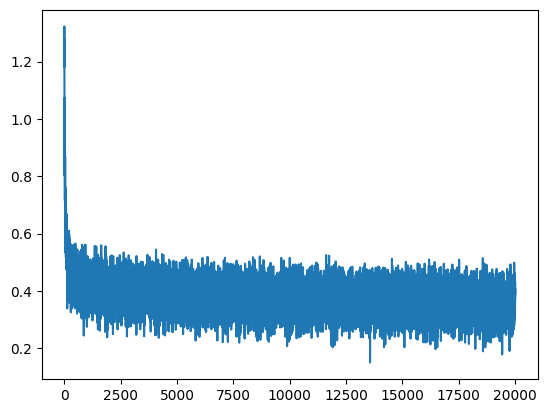

In [39]:
plt.plot(lossi)

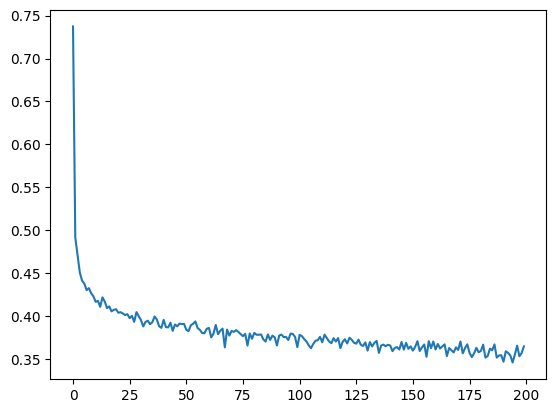

In [46]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [40]:
# put layers in eval mode
for layer in layers:
  layer.training = False

In [41]:

import torch
# evaluate the loss 
@torch.no_grad()

def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte)
  }[split]
  
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
  for layer in layers:
    x = layer(x) # passing through the layers, layer by layer
  
  logits = x
  
  loss = F.cross_entropy(logits, y)
  return loss
  
print(split_loss('train').item())

2.2693474292755127


In [45]:
# sample from the model
import torch.nn.functional as F

for _ in range(20):
  
  out = []
  context = [0] * block_size # start with a context of zeros with length of block_size
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1) # concatenate the embeddings to a single vector
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples = 1, replacement=True).item()
    # append to the output
    out.append(ix)
    # update the context
    context = context[1:] + [ix] # shift the context and append the new characters
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))
    
    

  

jakhmer.
caan.
balysyne.
ashaw.
jayren.
raaryen.
alalynn.
asais.
shaorana.
elajey.
camarosa.
anejasia.
kianre.
kelber.
aleaoni.
amarie.
emsoston.
fjaa.
ashann.
jaselyn.
